# Data Visualization

In [1]:
import pandas as pd
import numpy as np
import os
import utilities as utils
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances;
%matplotlib widget

In [ ]:
import importlib
importlib.reload(utils)

In [2]:
dataset = 'dataset'

In [3]:
labels = []
cgr_mats = []
#cgr_flattened = []
for dir1 in [dir for dir in os.listdir(dataset) if not dir.startswith('.')]:
    for file in os.listdir(os.path.join(dataset, dir1, dir1)):
        path_to_file = os.path.join(dataset,dir1,dir1,file)
        sequence = utils.read_sequence(path_to_file)
        tmp = utils.cgr(sequence, 'ACGT', 6)
        cgr_mats.append(tmp)
        labels.append(path_to_file.split('/')[1])
        #cgr_flattened.append(tmp.flatten())

In [4]:
new_cgrs = []
new_labs = []
for lab in np.unique(labels):
    idxs = np.where(np.array(labels) == lab)[0]
    new_labs.append(lab)
    new_cgrs.append(np.sum(np.array(cgr_mats)[idxs], axis=0))
vector_cgrs = [mat.flatten() for mat in new_cgrs]
print(np.array(new_cgrs).shape)

(11, 64, 64)


In [5]:
normalized_mats = [(mat-np.mean(mat))/np.std(mat) for mat in new_cgrs]
vector_cgrs = [mat.flatten() for mat in normalized_mats]


In [6]:
np.array(normalized_mats).shape

(11, 64, 64)

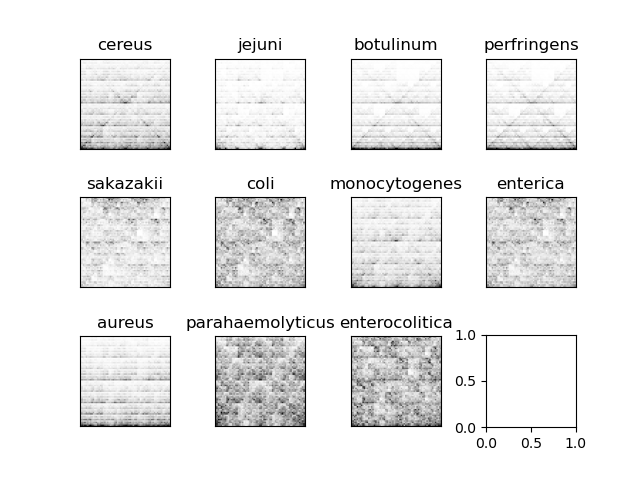

In [7]:
fig,ax = plt.subplots(3,4)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for ax,cgr,lab in zip(ax.flatten(), normalized_mats, new_labs):
    ax.set_title(lab.split('_')[-1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(cgr, cmap='gray_r')
plt.show()


In [8]:
D = pairwise_distances(vector_cgrs, metric='manhattan')

In [9]:
np.all(np.diag(D) == 0)

True

In [10]:
np.all(D == D.T)

True

In [11]:
reduced = utils.perform_mds(D, 3, random_state=0)

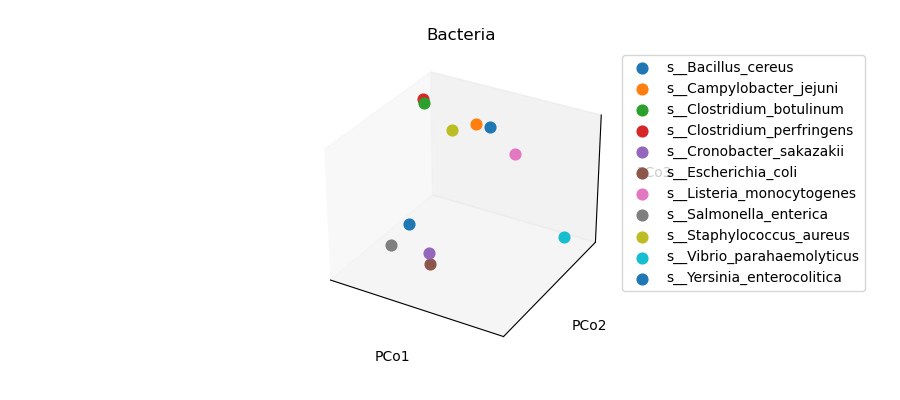

In [13]:
utils.plot_3d(reduced, new_labs)